In [ ]:
# Set global path
import sys
sys.path.append("../")

## Load model

In [1]:
# The data path for the trained clip model
path = '/scratch/zxs/scripts/starllm/back2/AstroCLIP/astroclip/outputs/astroclip-alignment/9gj1ewke/checkpoints/'

In [2]:
from astroclip.models import AstroClipModel
import torch
model = AstroClipModel.load_from_checkpoint(
    checkpoint_path = path+"last.ckpt",
)

/home/zxs/.conda/envs/starllm2/lib/python3.10/site-packages/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/zxs/.conda/envs/starllm2/lib/python3.10/site-packages/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/zxs/.conda/envs/starllm2/lib/python3.10/site-packages/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
/home/zxs/.conda/envs/starllm2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:263: UserWarning: Attribute 'image_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['image_encoder'])`.
  rank_zero_warn(
/home/zxs/.conda/envs/starllm2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:263: UserWarning:

## Extract clip representations and preprocess datasets

In [3]:
# load the datasets:
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk

loaded_dataset_dict = load_from_disk('/scratch/zxs/scripts/starllm/back2/AstroCLIP/astroclip/datasets/astroclip_file8_nonan_filtergalaxy2')
train_images = loaded_dataset_dict['train']['images']  # This gets the whole image array

In [4]:
# image
train_image = torch.tensor(loaded_dataset_dict['train']['images'])
test_image = torch.tensor(loaded_dataset_dict['test']['images'])
# spectra
train_spectra = torch.tensor(loaded_dataset_dict['train']['spectrum'])
test_spectra = torch.tensor(loaded_dataset_dict['test']['spectrum'])

In [5]:
# embedding for training SBI
train_emed_clip_image = model.image_encoder(train_image)
train_emed_clip_spectra = model.spectrum_encoder(train_spectra)
# embedding for testing SBI
test_emed_clip_image = model.image_encoder(test_image)
test_emed_clip_spectra = model.spectrum_encoder(test_spectra)

In [6]:
# features for training SBI
train_Z = torch.tensor(loaded_dataset_dict['train']['Z']).reshape(-1,1)
train_logg = torch.tensor(loaded_dataset_dict['train']['logg']).reshape(-1,1)
train_Teff = torch.tensor(loaded_dataset_dict['train']['Teff']).reshape(-1,1)
train_FeH = torch.tensor(loaded_dataset_dict['train']['FeH']).reshape(-1,1)
train_features = torch.cat((train_Teff,train_FeH,train_logg,train_Z),axis=1)

# features for testing SBI
test_Z = torch.tensor(loaded_dataset_dict['test']['Z']).reshape(-1,1)
test_logg = torch.tensor(loaded_dataset_dict['test']['logg']).reshape(-1,1)
test_Teff = torch.tensor(loaded_dataset_dict['test']['Teff']).reshape(-1,1)
test_FeH = torch.tensor(loaded_dataset_dict['test']['FeH']).reshape(-1,1)
test_features = torch.cat((test_Teff,test_FeH,test_logg,test_Z),axis=1)

In [7]:
# normalize the features
def norm_feature(train_features, test_features):
    mean = torch.mean(train_features,axis=0)
    std = torch.std(train_features,axis=0)
    train_normed_features =train_features-mean
    train_normed_features /=std

    test_normed_features =test_features-mean
    test_normed_features /=std
    return mean, std, train_normed_features, test_normed_features
# normed training and testing feature
mean, std, train_normed_features, test_normed_features = norm_feature(train_features,test_features)

(array([  1.,   2.,   7.,  25.,  75., 140., 136.,  82.,  20.,   6.]),
 array([-4.43032598, -3.68780375, -2.94528174, -2.2027595 , -1.46023738,
        -0.71771526,  0.02480688,  0.76732904,  1.50985122,  2.25237322,
         2.99489546]),
 <BarContainer object of 10 artists>)

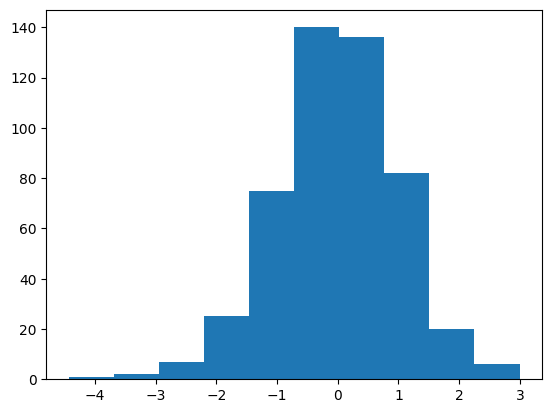

In [8]:
plt.hist(train_normed_features[:,3])

In [11]:
print ('************prior**************:')
feature_name = ['Teff','FeH','logg','Z']
priors = torch.zeros((4,2))
for i in range(train_normed_features.shape[1]):
    print ("{}, min: {}, max: {}:".format(feature_name[i],train_normed_features[:,i].min(),train_normed_features[:,i].max()))
    priors[i,0] = train_normed_features[:,i].min()
    priors[i,1] = train_normed_features[:,i].max()
print (priors)

************prior**************:
Teff, min: -3.2495687007904053, max: 3.250262975692749:
FeH, min: -5.2271342277526855, max: 2.4671742916107178:
logg, min: -5.529545307159424, max: 1.4380689859390259:
Z, min: -4.430325984954834, max: 2.9948954582214355:
tensor([[-3.2496,  3.2503],
        [-5.2271,  2.4672],
        [-5.5295,  1.4381],
        [-4.4303,  2.9949]])


## Train SBI

In [12]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference.base import infer

In [13]:
# convert the priors to the sbi format
prior_sbi = utils.BoxUniform(low=priors[:,0], high=priors[:,1])

In [14]:
# train sbi
from sbi.inference import SNPE
inference = SNPE(prior=prior_sbi)
_ = inference.append_simulations(train_normed_features.clone().detach(), train_emed_clip_image.clone().detach()).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 27 epochs.

In [15]:
# for a specific observation
true_params = test_normed_features[0]
labels_params = ['Teff','FeH','logg','Z']

samples = posterior.sample((10000,), x=test_emed_clip_image.clone().detach()[0])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

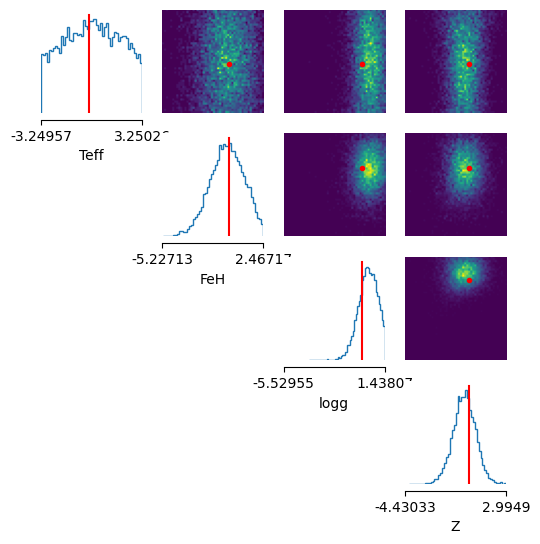

In [57]:
fig, axes = analysis.pairplot(
    samples,
    limits=priors,
    ticks=priors,
    figsize=(6, 6),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=labels_params,
);

### Unnormalized features (parameters)

In [53]:
true_params_unn = true_params*std.reshape(1,-1)+mean.reshape(1,-1)
priors_unn = priors*std.reshape(-1,1)+mean.reshape(-1,1)
features_unn = samples*std.reshape(1,-1)+mean.reshape(1,-1)

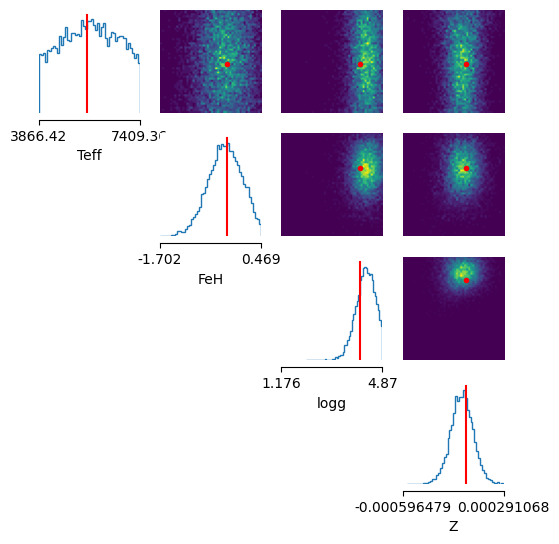

In [58]:
fig, axes = analysis.pairplot(
    features_unn,
    limits=priors_unn,
    ticks=priors_unn,
    figsize=(6, 6),
    points=true_params_unn,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=labels_params,
);